In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [45]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [85]:
train = pd.read_csv('train 3.csv')

In [130]:
col_list = train.columns

In [128]:
col_list = list(col_list)[1:]

In [88]:
full = pd.read_csv('covtype.data', names=col_list)

In [89]:
#convert Id & Cover Type to strings, since they are not numeric features
train['Id'] = train['Id'].apply(str)
train['Cover_Type'] = train['Cover_Type'].apply(str)
full['Cover_Type'] = full['Cover_Type'].apply(str)

In [142]:
#Turn wilderness area binary columns into categorical values
train['Wilderness_Area'] = train['Wilderness_Area1']
train['Wilderness_Area'][train['Wilderness_Area2'] == 1] = 2
train['Wilderness_Area'][train['Wilderness_Area3'] == 1] = 3
train['Wilderness_Area'][train['Wilderness_Area4'] == 1] = 4
train['Wilderness_Area']= train['Wilderness_Area'].apply(str)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [147]:
#turn Soil Type into a categorical value
train['Soil_Type'] = 0
for i in range(1,40):
    train['Soil_Type'][train['Soil_Type'+str(i)]==1] = i

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [150]:
train['Soil_Type'] = train['Soil_Type'].apply(str)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Wilderness_Area,Soil_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,5,1,29


In [72]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(full.head(1))

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [73]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(train.head(1))

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [77]:
full.nsmallest(10,'Hillshade_9am')

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
2241,2618,301,52,124,59,1789,0,157,231,1396,...,0,0,0,0,0,0,0,0,0,6
237789,2630,285,52,134,74,1782,0,173,248,1383,...,0,0,0,0,0,0,0,0,0,6
238258,2643,299,51,150,86,1761,0,159,233,1371,...,0,0,0,0,0,0,0,0,0,6
391119,2922,279,47,60,22,2491,0,194,252,792,...,0,0,0,0,0,0,0,0,0,1
391753,2918,273,50,90,25,2496,0,192,254,780,...,0,0,0,0,0,0,0,0,0,1
392384,2925,275,50,120,32,2501,0,191,254,769,...,0,0,0,0,0,0,0,0,0,1
403049,2893,294,49,424,-17,2796,0,172,240,297,...,0,1,0,0,0,0,0,0,0,1
479787,3200,296,30,124,49,2952,0,214,225,1103,...,1,0,0,0,0,0,0,0,0,2
479788,3224,310,55,134,70,2982,0,135,214,1131,...,1,0,0,0,0,0,0,0,0,2
480337,3194,212,30,182,42,2947,0,251,190,1127,...,1,0,0,0,0,0,0,0,0,2


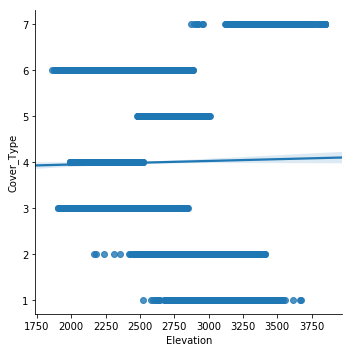

In [46]:
sns.lmplot(x='Elevation', y='Cover_Type', data=train)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


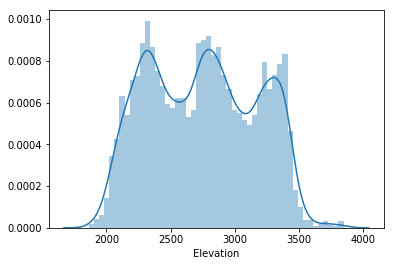

In [54]:
sns.distplot(train['Elevation'], bins=50)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


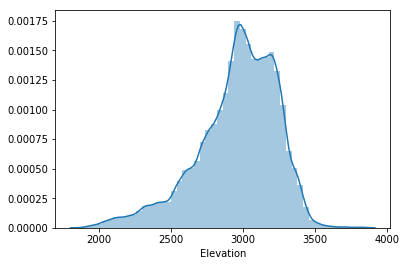

In [55]:
sns.distplot(full['Elevation'], bins=50)

In [61]:
full.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [69]:
full.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


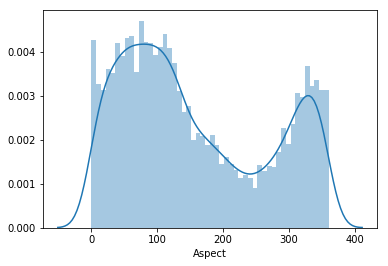

In [90]:
sns.distplot(train['Aspect'], bins=50);

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


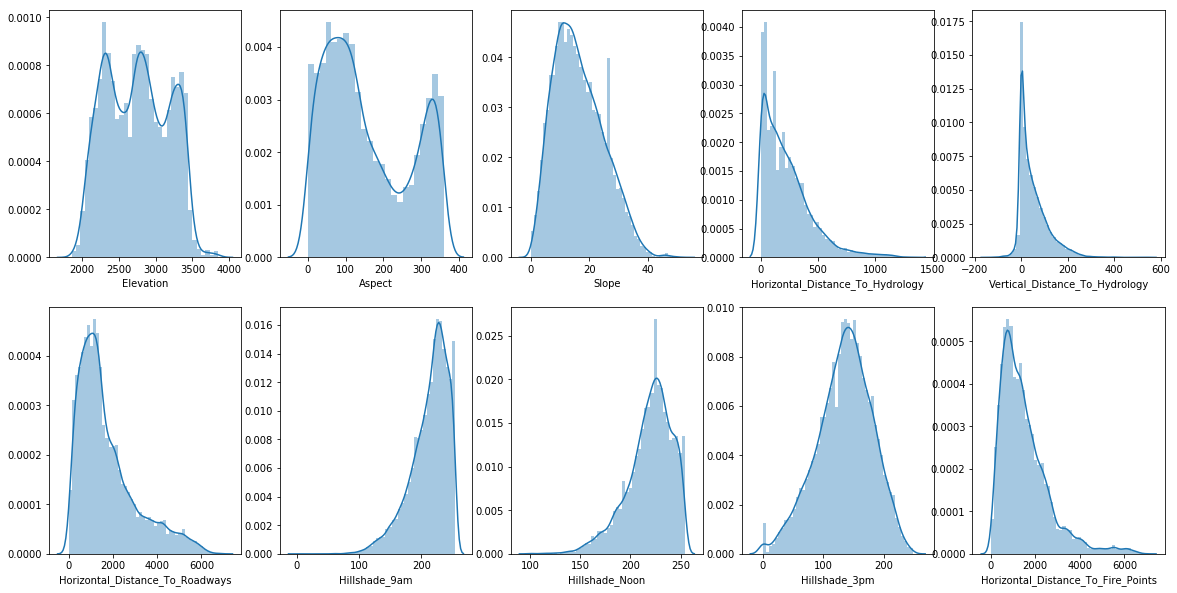

In [95]:
fig,axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
sns.distplot(train['Elevation'], ax=axs[0,0])
sns.distplot(train['Aspect'], ax=axs[0,1])
sns.distplot(train['Slope'], ax=axs[0,2])
sns.distplot(train['Horizontal_Distance_To_Hydrology'], ax=axs[0,3])
sns.distplot(train['Vertical_Distance_To_Hydrology'], ax=axs[0,4])
sns.distplot(train['Horizontal_Distance_To_Roadways'], ax=axs[1,0])
sns.distplot(train['Hillshade_9am'], ax=axs[1,1])
sns.distplot(train['Hillshade_Noon'], ax=axs[1,2])
sns.distplot(train['Hillshade_3pm'], ax=axs[1,3])
sns.distplot(train['Horizontal_Distance_To_Fire_Points'], ax=axs[1,4])

In [98]:
cols_to_corr=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points' ]

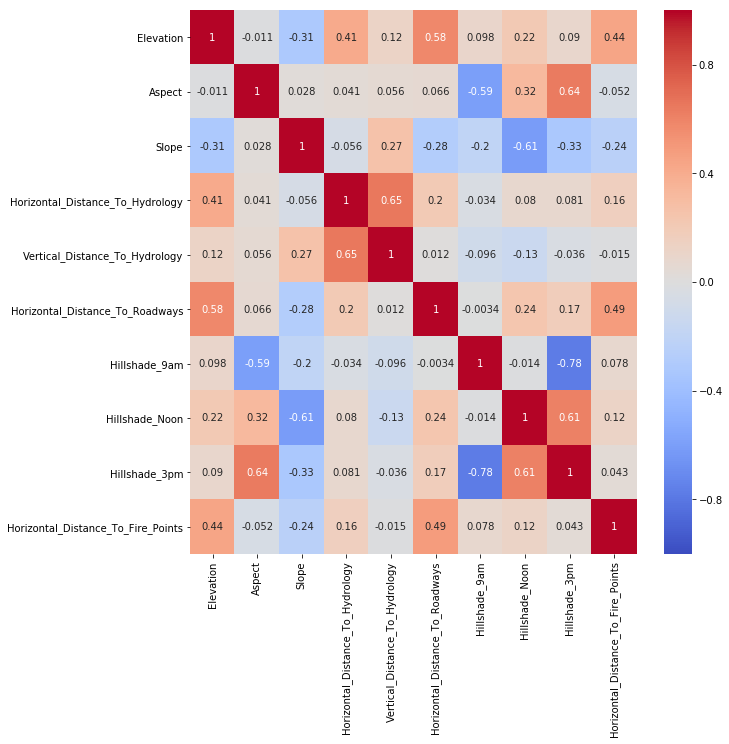

In [103]:
plt.subplots(figsize=(10,10))
sns.heatmap(train[cols_to_corr].corr(), vmin=-1, vmax=1, cmap='coolwarm',annot=True)

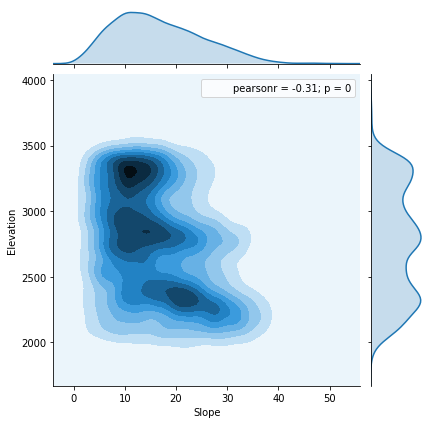

In [106]:
sns.jointplot(x='Slope',y='Elevation', data=train, kind='kde')

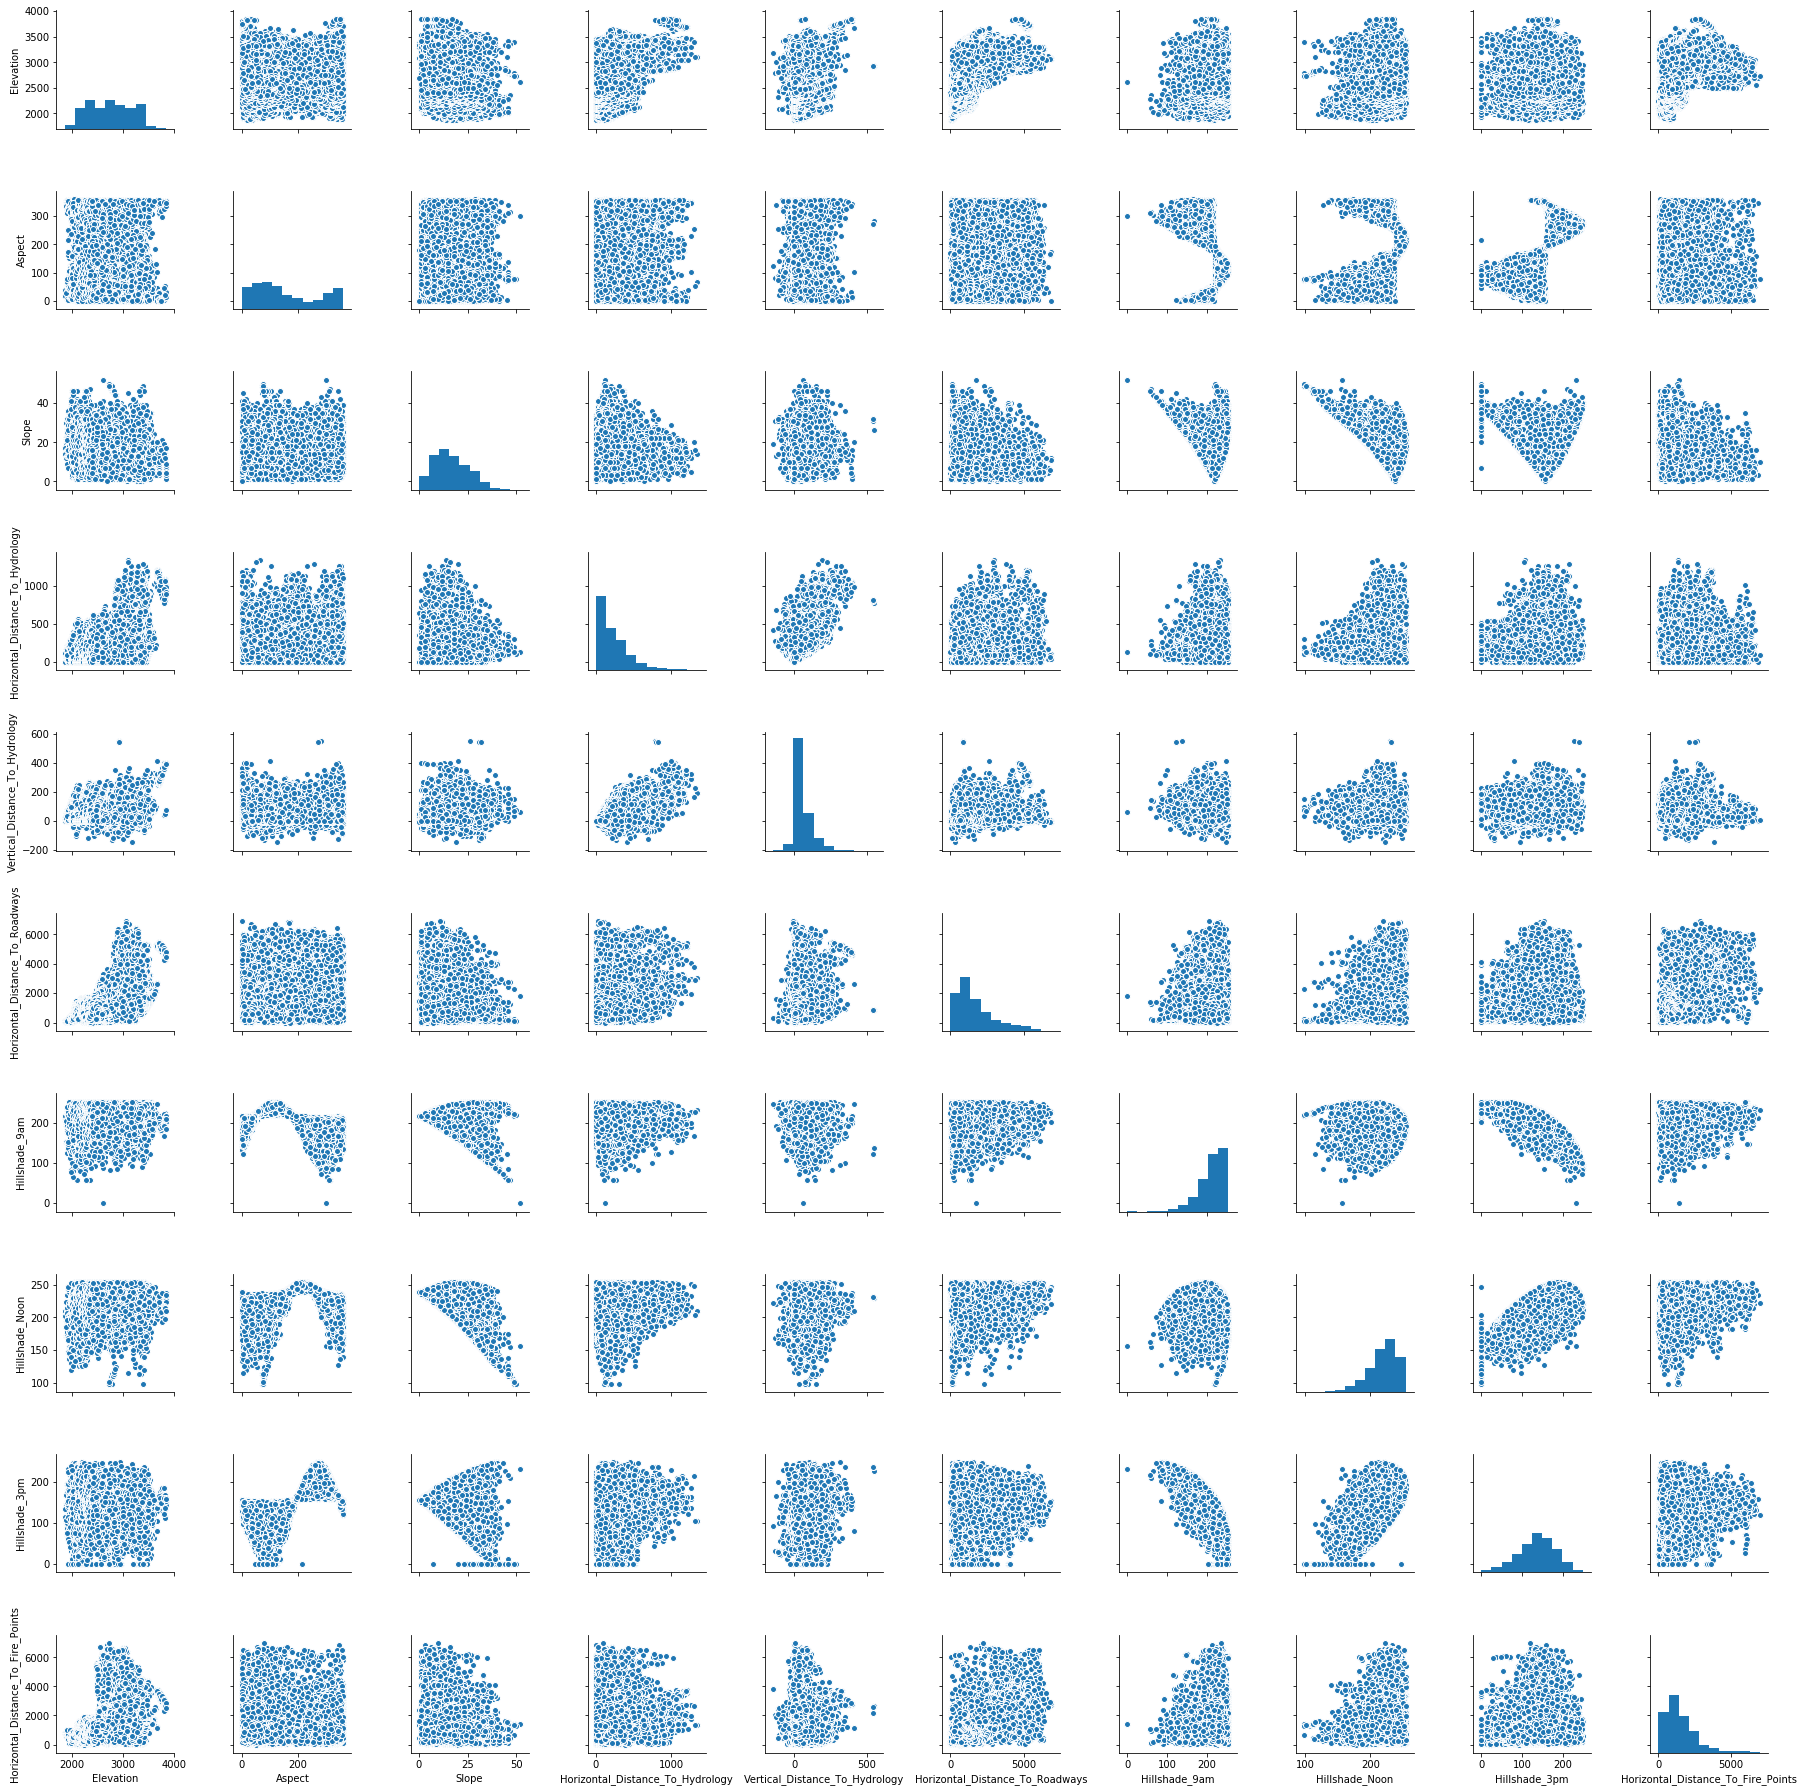

In [107]:
sns.pairplot(train[cols_to_corr])

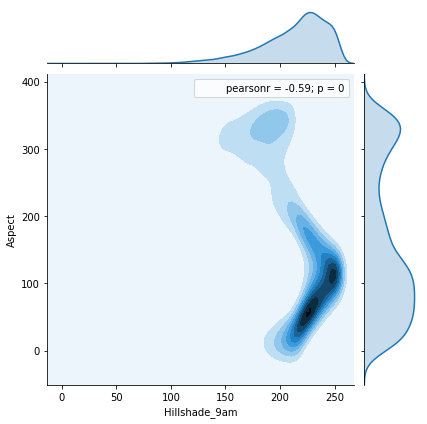

In [108]:
sns.jointplot(x='Hillshade_9am',y='Aspect', data=train, kind='kde')

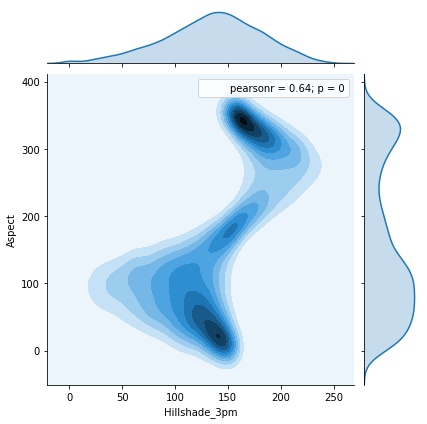

In [109]:
sns.jointplot(x='Hillshade_3pm',y='Aspect', data=train, kind='kde')

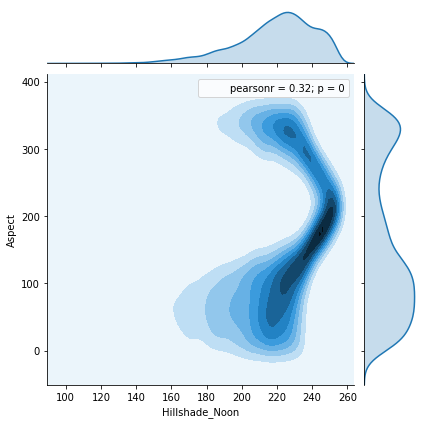

In [110]:
sns.jointplot(x='Hillshade_Noon',y='Aspect', data=train, kind='kde')

In [113]:
scaler = preprocessing.StandardScaler()

In [120]:
train_scaled = scaler.fit_transform(train)

In [122]:
train_scaled

array([[-1.73193626, -0.36709512, -0.95997982, ..., -0.21313437,
        -0.1769394 ,  0.5       ],
       [-1.73170715, -0.38146072, -0.9145592 , ..., -0.21313437,
        -0.1769394 ,  0.5       ],
       [-1.73147804,  0.1309124 , -0.16057691, ..., -0.21313437,
        -0.1769394 , -1.        ],
       ...,
       [ 1.73147804, -0.61609888, -0.20599753, ..., -0.21313437,
        -0.1769394 , -0.5       ],
       [ 1.73170715, -0.62807021,  0.09377856, ..., -0.21313437,
        -0.1769394 , -0.5       ],
       [ 1.73193626, -0.65680142,  0.36630228, ..., -0.21313437,
        -0.1769394 , -0.5       ]])

In [131]:
df = pd.DataFrame(train_scaled, columns=col_list)

In [132]:
df

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,-1.731936,-0.367095,-0.959980,-1.597132,0.146639,-0.834074,-0.908681,0.271454,0.571653,0.281259,...,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939,0.5
1,-1.731707,-0.381461,-0.914559,-1.715424,-0.072337,-0.932054,-0.999246,0.238732,0.703225,0.346627,...,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939,0.5
2,-1.731478,0.130912,-0.160577,-0.887379,0.194243,0.227369,1.106379,0.696843,0.834797,-0.002005,...,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939,-1.0
3,-1.731249,0.085421,-0.015231,0.177250,0.070474,1.092853,1.038455,0.827731,0.834797,-0.285268,...,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939,-1.0
4,-1.731020,-0.369489,-1.014485,-1.715424,-0.353198,-0.850404,-0.998491,0.238732,0.659368,0.324838,...,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939,0.5
5,-1.730791,-0.407798,-0.224166,-1.242255,0.346574,-1.079023,-1.243015,0.565954,0.790940,0.106943,...,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939,-1.0
6,-1.730562,-0.343152,-1.014485,-1.123963,0.203764,-0.752425,-0.815853,0.304176,0.264652,0.063364,...,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939,0.5
7,-1.730333,-0.345547,-0.978148,-1.478839,0.032391,-0.719765,-0.861135,0.304176,0.483939,0.194101,...,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939,0.5
8,-1.730103,-0.316816,-1.014485,-0.887379,0.060953,0.080400,-0.790947,0.336898,0.089223,-0.045584,...,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939,0.5
9,-1.729874,-0.328787,-0.887307,-0.769087,0.094276,-0.654445,-0.813589,0.500509,0.001508,-0.241689,...,-0.218671,-0.206085,-0.038173,-0.082413,-0.025726,-0.047474,-0.224908,-0.213134,-0.176939,0.5


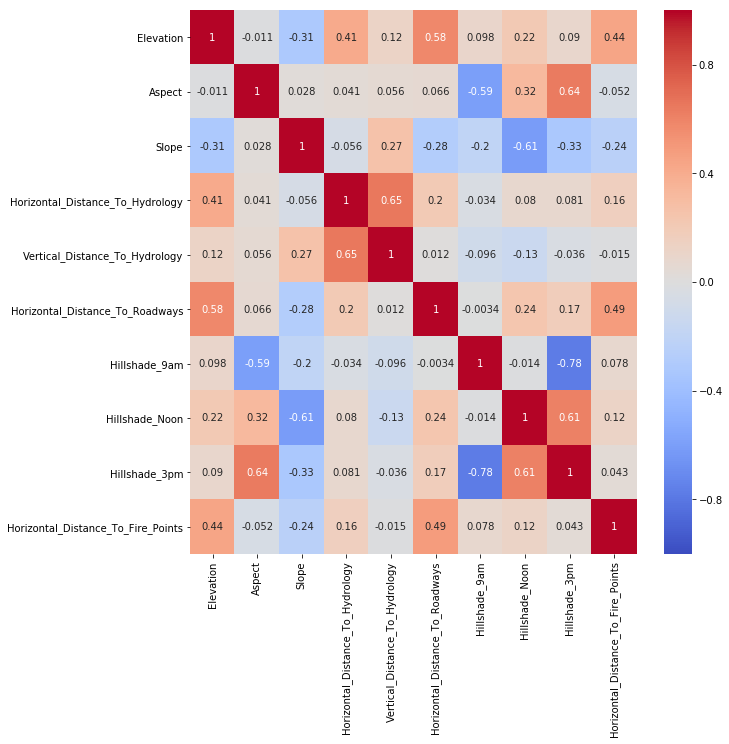

In [133]:
plt.subplots(figsize=(10,10))
sns.heatmap(df[cols_to_corr].corr(), vmin=-1, vmax=1, cmap='coolwarm',annot=True)

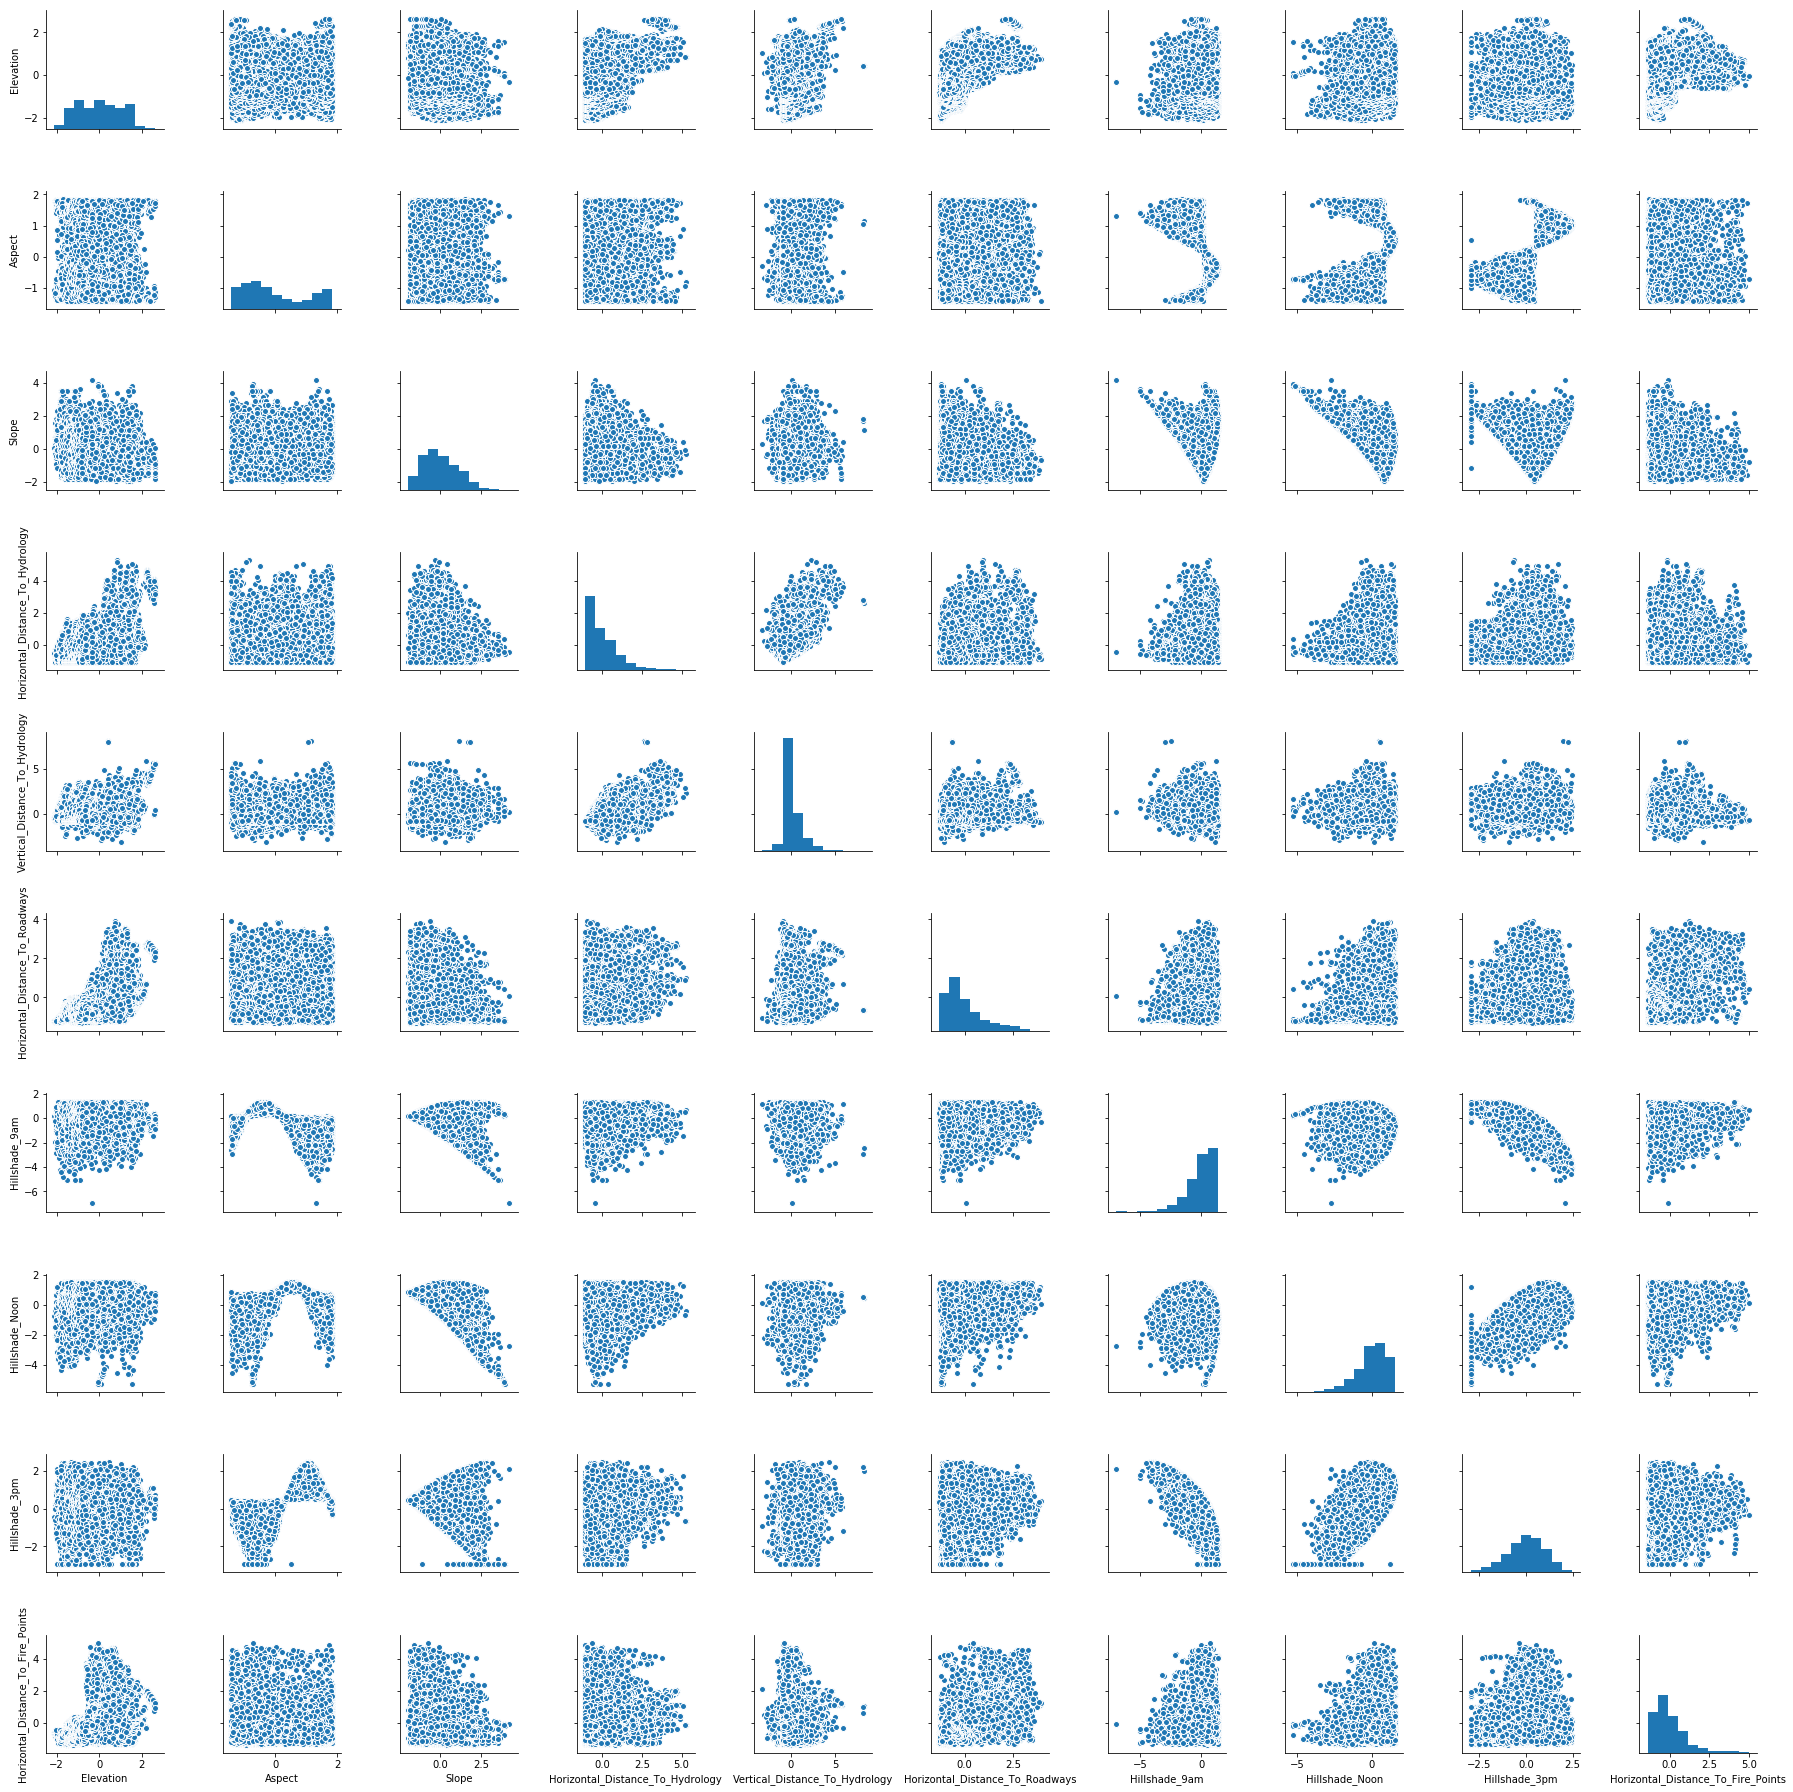

In [134]:
sns.pairplot(df[cols_to_corr])

3    6349
4    4675
1    3597
2     499
Name: Wilderness_Area, dtype: int64